In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
RESOURCE_PATH = f"{PROJECT_PATH}/Resource"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Single target processing
TARGET_NAME = "153_B"
ORIGINAL_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Original"
INTERMEDIATE_FILES_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/IntermediateFiles"
COMPARISON_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Comparison"
RESULT_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Result"

# Input image file
INPUT_IMAGE = f"{ORIGINAL_PATH}/153_B.jpg"

# Vectorization input - the edited image from Qwen
VECTORIZATION_INPUT = f"{INTERMEDIATE_FILES_PATH}/153_B_qwen_edit.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
# Install dependencies (removed duplicates)
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml

# Install vectorization dependencies
%pip install skan rdp

import shutil
import subprocess

# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%h|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit: {hash_code} ({commit_time.split()[0]}) - {commit_msg}")

# 3. Add code path to Python sys.path
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = ['sam_processor', 'svglib', 'utils']

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Modules reloaded!")

Code repository successfully cloned
Latest commit: ec6be08 (2025-10-02) - optimize smooth_open 1
Modules reloaded!


✅ 提取了 293 条路径，已保存到: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_raw.svg


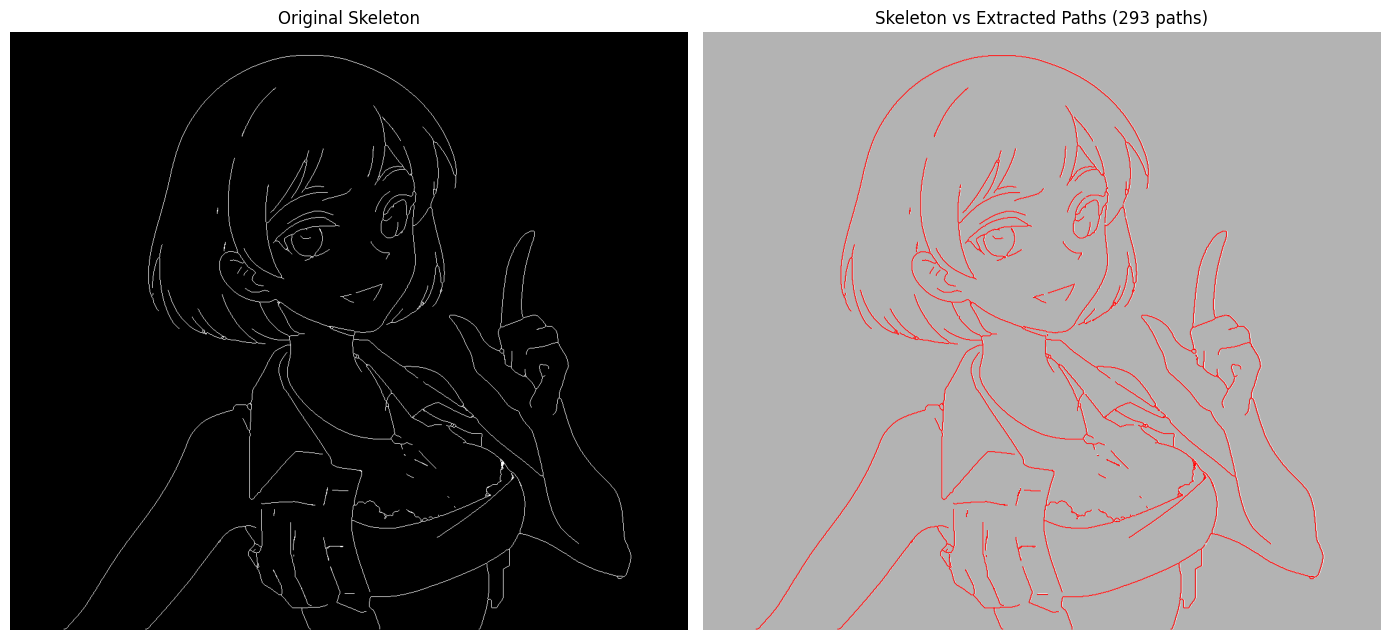

In [ ]:
# ==================== Skeleton to SVG Conversion ====================

import os
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
from svglib.svg import SVG
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.geom import Bbox
import matplotlib.pyplot as plt

def extract_open_paths(skeleton):
    """Extract open paths from skeleton"""
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    labeled = label(skeleton_binary)
    regions = regionprops(labeled)

    paths = []
    for region in regions:
        coords = region.coords
        if len(coords) < 2:
            continue

        # Count neighbors for each point
        def count_neighbors(point, all_coords):
            cnt = 0
            for c in all_coords:
                if (abs(c[0] - point[0]) <= 1 and abs(c[1] - point[1]) <= 1 and tuple(c) != tuple(point)):
                    cnt += 1
            return cnt

        endpoints = [p for p in coords if count_neighbors(p, coords) == 1]
        remaining = set(tuple(c) for c in coords)

        while remaining:
            # Prioritize starting from endpoints
            start = None
            if endpoints:
                for ep in endpoints:
                    if tuple(ep) in remaining:
                        start = ep
                        break
            if start is None:
                start = next(iter(remaining))

            # Trace path
            path_coords = []
            cur = start
            path_coords.append((int(cur[1]), int(cur[0])))
            remaining.remove(tuple(cur))

            while remaining:
                nxt = None
                for c in list(remaining):
                    if (abs(c[0] - cur[0]) <= 1 and abs(c[1] - cur[1]) <= 1):
                        nxt = c
                        break
                if nxt is None:
                    break
                path_coords.append((int(nxt[1]), int(nxt[0])))
                remaining.remove(nxt)
                cur = nxt

            if len(path_coords) >= 2:
                paths.append(path_coords)

    return paths

def build_svg_paths(paths):
    """Convert paths to SVG path objects"""
    svg_paths = []
    for path in paths:
        d = f"M {path[0][0]:.2f} {path[0][1]:.2f}"
        for x, y in path[1:]:
            d += f" L {x:.2f} {y:.2f}"
        path_group = SVGPath.from_str(d, add_closing=False)
        svg_paths.extend(path_group.svg_paths)
    return svg_paths

def visualize_results(skeleton, paths):
    """Visualize comparison results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Original skeleton
    axes[0].imshow(skeleton, cmap='gray')
    axes[0].set_title('Original Skeleton')
    axes[0].axis('off')

    # Skeleton vs extracted paths comparison
    axes[1].imshow(skeleton, cmap='gray', alpha=0.3)
    for path in paths:
        path_array = np.array(path)
        axes[1].plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=0.8, alpha=0.8)
    axes[1].set_title(f'Skeleton vs Extracted Paths ({len(paths)} paths)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Main process
skeleton_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_skeleton.png")
if os.path.exists(skeleton_path):
    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE) > 0
    paths = extract_open_paths(skeleton)

    if paths:
        svg_paths = build_svg_paths(paths)
        viewbox = Bbox(0, 0, skeleton.shape[1], skeleton.shape[0])
        group = SVGPathGroup(svg_paths, fill=False, stroke_width=2.0)

        # Ensure paths have filling attribute
        for sp in group.svg_paths:
            if not hasattr(sp, 'filling'):
                sp.filling = 0

        svg = SVG([group], viewbox=viewbox)
        raw_svg_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_raw.svg")
        svg.save_svg(raw_svg_path, coordinate_precision=1)

        print(f"✅ Extracted {len(paths)} paths, saved to: {raw_svg_path}")

        # Visualize results
        visualize_results(skeleton, paths)
    else:
        print("❌ Path extraction failed")
else:
    print("❌ Skeleton image does not exist")

Rendering raw SVG...
1. Simplifying paths...
2. Converting to bezier...


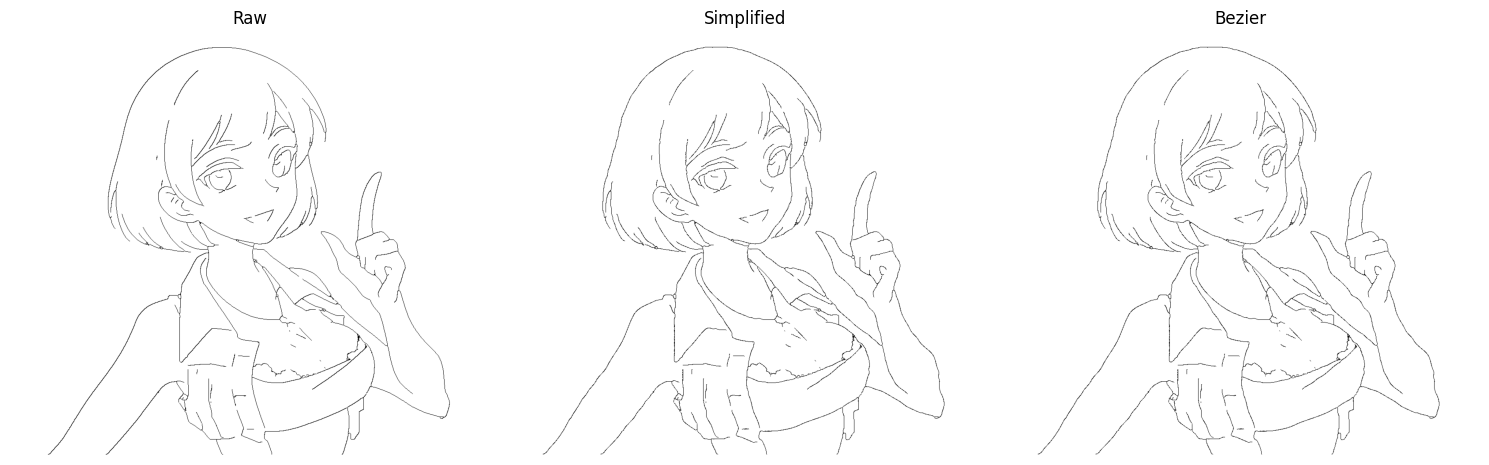


✅ Optimization complete!
File size: 197.9KB → 66.3KB → 66.3KB
Reduction: 66.5% after simplification
Bezier vs Raw: 66.5% reduction


In [ ]:
# ==================== SVG路径优化 ====================

import os
import numpy as np
import matplotlib.pyplot as plt
from svglib.svg import SVG

# ========== 优化参数配置 ==========
# tolerance: 简化容差(像素)，越大简化越激进，点越少，但可能失真
SIMPLIFY_TOLERANCE = 2.0      # 简化容差 (适中)

# angle_threshold: 角度阈值(度)，当相邻两段路径夹角接近180度时合并点
# - 179: 几乎直线才合并(默认，保守)
# - 170: 轻微弯曲也合并
# - 165: 适中，平衡细节和大小
# - 160-150: 中度弯曲也合并(激进)
# - <150: 很激进，可能丢失明显的拐角
ANGLE_THRESHOLD = 175.0       # 简化的角度阈值 (适中偏激进)

# epsilon: 拟合精度，越小拟合越精确
EPSILON = 0.1                 # 较精确的拟合

# force_smooth: 是否强制平滑曲线
FORCE_SMOOTH = True

# coordinate_precision: SVG坐标精度(小数位数)
COORDINATE_PRECISION = 0      # 整数坐标

# 读取原始SVG
raw_svg_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_raw.svg")

def render_svg_to_image(svg_file):
    """渲染SVG为白底黑线图像"""
    import cv2
    svg = SVG.load_svg(svg_file)
    h, w = int(svg.viewbox.wh.y), int(svg.viewbox.wh.x)
    img = np.ones((h, w), dtype=np.uint8) * 255

    for path_group in svg.svg_path_groups:
        for svg_path in path_group.svg_paths:
            # 使用svglib内置的sample_points方法来正确采样贝塞尔曲线
            points_array = svg_path.sample_points(max_dist=0.5)  # 每0.5像素采样一个点
            if len(points_array) >= 2:
                # 转换为整数坐标
                points_int = points_array.astype(np.int32)
                cv2.polylines(img, [points_int], isClosed=False, color=0, thickness=1)

    return img

stages = []
stage_names = ['Raw', 'Simplified', 'Bezier']

# 0. 原始状态
print("Rendering raw SVG...")
stages.append(render_svg_to_image(raw_svg_path))

# 1. 路径简化 (使用angle_threshold激进简化)
print("1. Simplifying paths...")
svg = SVG.load_svg(raw_svg_path)
svg.filter_consecutives().filter_duplicates()
svg.simplify(tolerance=SIMPLIFY_TOLERANCE,
             epsilon=EPSILON,
             angle_threshold=ANGLE_THRESHOLD,
             force_smooth=FORCE_SMOOTH)
simplified_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_simplified.svg")
svg.save_svg(simplified_path, coordinate_precision=COORDINATE_PRECISION)
stages.append(render_svg_to_image(simplified_path))

# 2. 转换为贝塞尔曲线
print("2. Converting to bezier...")
svg.line_to_bezier()
bezier_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_bezier.svg")
svg.save_svg(bezier_path, coordinate_precision=COORDINATE_PRECISION)
stages.append(render_svg_to_image(bezier_path))

# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (stage, name) in enumerate(zip(stages, stage_names)):
    axes[i].imshow(stage, cmap='gray', vmin=0, vmax=255)
    axes[i].set_title(name)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 文件大小对比
raw_size = os.path.getsize(raw_svg_path) / 1024
simp_size = os.path.getsize(simplified_path) / 1024
bez_size = os.path.getsize(bezier_path) / 1024
print(f"\n✅ Optimization complete!")
print(f"File size: {raw_size:.1f}KB → {simp_size:.1f}KB → {bez_size:.1f}KB")
print(f"Reduction: {(1-simp_size/raw_size)*100:.1f}% after simplification")
print(f"Bezier vs Raw: {(1-bez_size/raw_size)*100:.1f}% reduction")



Loading bezier SVG...
  Commands: 816

🛡️ Applying smooth_open (tension=1)...
  After smooth: 816 commands

🛡️ Applying simplify (tolerance=1.5, angle=179.5)...
  After simplify: 653 commands


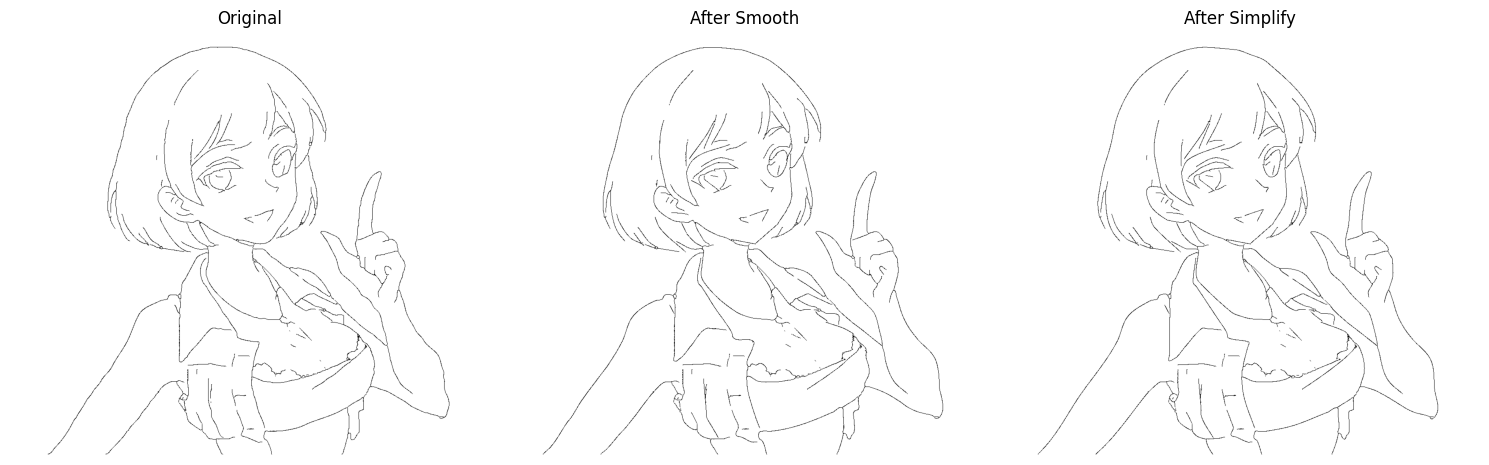


✅ Optimization complete!
Commands: 816 → 816 → 653
Total reduction: +20.0%

📊 File sizes:
  Original: 66.3KB
  Smoothed: 66.3KB
  Optimized: 62.4KB
  Reduction: +6.0%


In [94]:
# ==================== Bezier Curve Smooth + Simplify (Most Conservative - Single Pass) ====================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from svglib.svg import SVG

# ========== Parameters (Most Conservative) ==========
SMOOTH_TENSION = 1              # 👈 平滑强度（0.3=保守）
SIMPLIFY_TOLERANCE = 1.5          # 👈 非常保守（只允许1.5像素误差）
SIMPLIFY_ANGLE_THRESHOLD = 179.5  # 👈 极度保守（几乎不合并）

# Read bezier SVG
bezier_svg_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_bezier.svg")

def render_svg_to_image(svg_file):
    """Render SVG to image"""
    svg = SVG.load_svg(svg_file)
    h, w = int(svg.viewbox.wh.y), int(svg.viewbox.wh.x)
    img = np.ones((h, w), dtype=np.uint8) * 255
    for path_group in svg.svg_path_groups:
        for path in path_group.svg_paths:
            points_array = path.sample_points(max_dist=0.5).astype(np.int32)
            if len(points_array) >= 2:
                cv2.polylines(img, [points_array], isClosed=False, color=0, thickness=1)
    return img

# Load bezier SVG
print("Loading bezier SVG...")
svg = SVG.load_svg(bezier_svg_path)

stages = []
stage_names = []

# Stage 0: Original
stages.append(render_svg_to_image(bezier_svg_path))
stage_names.append('Original')

total_commands_before = sum(len(path.path_commands) for pg in svg.svg_path_groups for path in pg.svg_paths)
print(f"  Commands: {total_commands_before}")

# Step 1: Smooth (using local tangent method)
print(f"\n🛡️ Applying smooth_open (tension={SMOOTH_TENSION})...")
for path_group in svg.svg_path_groups:
    for path in path_group.svg_paths:
        try:
            path.smooth_open(tension=SMOOTH_TENSION)
        except Exception as e:
            pass

svg.filter_empty()
svg.filter_consecutives()

commands_after_smooth = sum(len(path.path_commands) for pg in svg.svg_path_groups for path in pg.svg_paths)
print(f"  After smooth: {commands_after_smooth} commands")

# 保存 smooth 后的中间文件
smoothed_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_smoothed.svg")
svg.save_svg(smoothed_path, coordinate_precision=0)

stages.append(render_svg_to_image(smoothed_path))
stage_names.append('After Smooth')

# Step 2: Simplify (single pass, very conservative)
print(f"\n🛡️ Applying simplify (tolerance={SIMPLIFY_TOLERANCE}, angle={SIMPLIFY_ANGLE_THRESHOLD})...")
for path_group in svg.svg_path_groups:
    for path in path_group.svg_paths:
        try:
            path.simplify(
                tolerance=SIMPLIFY_TOLERANCE,
                epsilon=0.05,
                angle_threshold=SIMPLIFY_ANGLE_THRESHOLD,
                force_smooth=False
            )
        except Exception as e:
            pass

svg.filter_empty()
svg.filter_consecutives()

commands_final = sum(len(path.path_commands) for pg in svg.svg_path_groups for path in pg.svg_paths)
print(f"  After simplify: {commands_final} commands")

# Final save
optimized_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_optimized.svg")
svg.save_svg(optimized_path, coordinate_precision=0)

stages.append(render_svg_to_image(optimized_path))
stage_names.append('After Simplify')

# Visualization (保持原有逻辑)
n_stages = len(stages)
n_cols = min(4, n_stages)
n_rows = (n_stages + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

if n_stages == 1:
    axes = [axes]
elif n_rows == 1:
    pass
else:
    axes = axes.flatten()

for i, (stage, name) in enumerate(zip(stages, stage_names)):
    ax = axes[i] if n_stages > 1 else axes[0]
    ax.imshow(stage, cmap='gray', vmin=0, vmax=255)
    ax.set_title(name, fontsize=12)
    ax.axis('off')

# Hide unused subplots
if n_stages > 1 and n_stages < len(axes):
    for i in range(n_stages, len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Summary
reduction = (1 - commands_final / total_commands_before) * 100
print(f"\n✅ Optimization complete!")
print(f"Commands: {total_commands_before} → {commands_after_smooth} → {commands_final}")
print(f"Total reduction: {reduction:+.1f}%")

# File sizes
bez_size = os.path.getsize(bezier_svg_path) / 1024
smooth_size = os.path.getsize(smoothed_path) / 1024
opt_size = os.path.getsize(optimized_path) / 1024
print(f"\n📊 File sizes:")
print(f"  Original: {bez_size:.1f}KB")
print(f"  Smoothed: {smooth_size:.1f}KB")
print(f"  Optimized: {opt_size:.1f}KB")
print(f"  Reduction: {(1 - opt_size/bez_size)*100:+.1f}%")